# *(Joglekar, et. al, 2018)*: Inter-areal Balanced Amplification Figure 1

Implementation of the figure 1 of:

- Joglekar, Madhura R., et al. "Inter-areal balanced amplification enhances signal propagation in a large-scale circuit model of the primate cortex." Neuron 98.1 (2018): 222-234.

In [1]:
import brainpy as bp
import brainpy.math as bm
from jax import vmap, jit
import numpy as np
import matplotlib.pyplot as plt

In [2]:
wIE = 4 + 2.0 / 7.0  # synaptic weight E to I
wII = wIE * 1.1  # synaptic weight I to I

In [3]:
class LocalCircuit(bp.DynamicalSystem):
  r"""The model is given by:

  .. math::

     \tau_E \frac{dv_E}{dt} = -v_E + a1 * [I_E]_+ + a2 * [I_I]_+ \\
     \tau_I \frac{dv_I}{dt} = -v_I + a2 * [I_E]_+ + a4 * [I_I]_+

  where :math:`[I_E]_+=max(I_E, 0)`. :math:`v_E` and :math:`v_I` denote the firing rates
  of the excitatory and inhibitory populations respectively, :math:`\tau_E` and
  :math:`\tau_I` are the corresponding intrinsic time constants.
  """

  def __init__(self, wEE, wEI, tau_e=0.02, tau_i=0.02):
    super(LocalCircuit, self).__init__()
    # parameters
    self.gc = bm.asarray([[wEE, -wEI],
                          [wIE, -wII]])
    self.tau = bm.asarray([tau_e, tau_i])  # time constant [s]
    # variables
    self.state = bm.Variable(bm.asarray([1., 0.]))

  def update(self, tdi):
    self.state += (-self.state + self.gc @ self.state) / self.tau * tdi.dt
    self.state.value = bm.maximum(self.state, 0.)


In [4]:
def simulate(wEE, wEI, duration, dt=0.0001, numpy_mon_after_run=True):
  model = LocalCircuit(wEE=wEE, wEI=wEI)
  runner = bp.DSRunner(model, monitors=['state'], dt=dt,
                       numpy_mon_after_run=numpy_mon_after_run,
                       progress_bar=False)
  runner.run(duration)
  return runner.mon.state


In [5]:

@jit
@vmap
def get_max_amplitude(wEE, wEI):
  states = simulate(wEE, wEI, duration=2., dt=0.0001, numpy_mon_after_run=False)
  return states[:, 0].max()


In [6]:
@jit
@vmap
def get_eigen_value(wEE, wEI):
  A = bm.array([[wEE, -wEI], [wIE, -wII]])
  w, _ = bm.linalg.eig(A)
  return w.real.max()

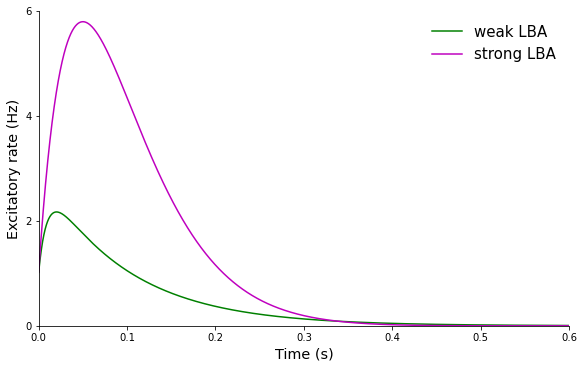

In [7]:
# =================== Figure 1B in the paper ==================================#

length, step = 0.6, 0.0001
wEEweak = 4.45  # synaptic weight E to E weak LBA
wEIweak = 4.7  # synaptic weight I to E weak LBA
wEEstrong = 6  # synaptic weight E to E strong LBA
wEIstrong = 6.7  # synaptic weight I to E strong LBA
weak = simulate(wEEweak, wEIweak, duration=length, dt=step)
strong = simulate(wEEstrong, wEIstrong, duration=length, dt=step)

fig, gs = bp.visualize.get_figure(1, 1, 5, 8)
ax = fig.add_subplot(gs[0, 0])
ax.plot(np.arange(step, length, step), weak[:, 0], 'g')
ax.plot(np.arange(step, length, step), strong[:, 0], 'm')
ax.set_ylabel('Excitatory rate (Hz)', fontsize='x-large')
ax.set_xlabel('Time (s)', fontsize='x-large')
ax.set_ylim([0, 6])
ax.set_xlim([0, length])
ax.set_yticks([0, 2, 4, 6])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(['weak LBA', 'strong LBA'], prop={'size': 15}, frameon=False)
plt.show()

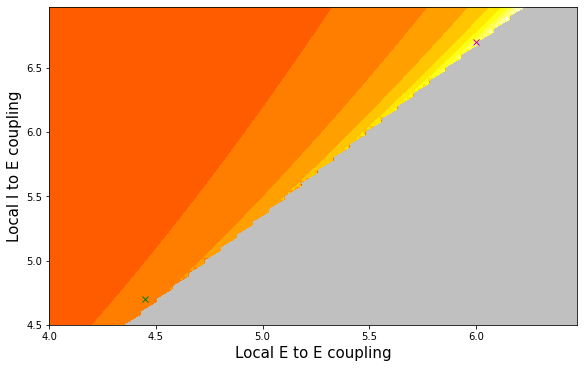

In [8]:
# =================== Figure 1C in the paper ==================================#

all_wEE = bm.arange(4, 6.5, .025)
all_wEI = bm.arange(4.5, 7, .025)
shape = (len(all_wEE), len(all_wEI))
max_amplitude = bm.ones(shape) * -5
all_wEE, all_wEI = bm.meshgrid(all_wEE, all_wEI)
# select all parameters lead to stable model
max_eigen_values = get_eigen_value(all_wEE.flatten(), all_wEI.flatten())
selected_ids = bm.where(max_eigen_values.reshape(shape) < 1)
# get maximum amplitude of each stable model
num = 100
for i in range(0, selected_ids[0].size, num):
  ids = (selected_ids[0][i: i + num], selected_ids[1][i: i + num])
  max_amps = get_max_amplitude(all_wEE[ids], all_wEI[ids])
  max_amplitude[ids] = max_amps

fig, gs = bp.visualize.get_figure(1, 1, 5, 8)
ax = fig.add_subplot(gs[0, 0])
X, Y = bm.as_numpy(all_wEE), bm.as_numpy(all_wEI)
levels = np.linspace(-5, 8, 20)
plt.contourf(X, Y, max_amplitude.numpy(), levels=levels, cmap='hot')
plt.contourf(X, Y, max_amplitude.numpy(), levels=np.linspace(-5, 0), colors='silver')
plt.plot(wEEstrong, wEIstrong, 'mx')
plt.plot(wEEweak, wEIweak, 'gx')
plt.ylabel('Local I to E coupling', fontsize=15)
plt.xlabel('Local E to E coupling', fontsize=15)
plt.show()